# A Python Code for Retrieving Rainfall at Ungauged Locations from Gridded Rainfall Products
The objective of this project is to retrieve rainfall reading at an ungauged location from gridded rainfall product using the latitude and longitude of that location. The code computes the distances between the location of interest (LOI) and the map coordinates, and then select the rainfall of the closest location to LOI as the rainfall at LOI. The gridded product can be in either hourly, daily, monthly, or yearly time intervals. 

A single rainfall map (in GeoTiff format) for the last 365 days (before April 26, 2020) for contiguous USA from the National Weather Service's (NWS) multi-sensor gridded rainfall product, which was downloaded via https://water.weather.gov/precip/download.php was used as an example data file to set up this code. However, the code should be compatible with GeoTiff files from other sources. In addition, the code can be easily modified to process multiple maps (i.e. stacked maps). Note: this project does not cover how to download gridded rainfall products (.Tiff file) and thus it is assummed that you have obtained the gridded data prior to using the procedure outlined below.


### Required packages:
Rasterio: Install the rasterio module using the command line, "conda install rasterio". An alternate command is "!pip install rasterio". 



### Import the modules

In [1]:
# Import modules

import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [2]:
# Obtain the current working directory
# This line of code does not play any major role in the project other than ensuring that we are working in the right directory.

glob.os.getcwd()


'C:\\Users\\parkernath32\\Dropbox\\Nathaniel Parker\\KSU_Coursework\\Spring 2020\\Introduction to Scientific Programming\\semester_project'


### User inputs:
1. Name of the Location of interest (LOI)
2. Latitude of LOI
3. Longitude of LOI


In [3]:
# User inputs

LOI = input('Enter location name')
lat_LOI = float(input('Enter latitude'))
lon_LOI = float(input('Enter longitude'))


Enter location name Manhattan
Enter latitude 39.183
Enter longitude -96.571


### Open the gridded map in python
It is very important to explore the data information (metadata) of the map after opening to determine whether any component of the data needs to be modified. For instance, knowing the coordinate reference system (CRS) of the data is important in interpreting how locations are represented on the map. It also helps to determine whether to change the CRS into latitude and longitudes for the computation of distances between LOI and the location points on the map.

In [17]:
# Load the GeoTiff file and explore the data information

data_file = 'nws_precip_last365days_20200426_conus.tif'
data = rasterio.open(data_file)
data.meta


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 1121,
 'height': 881,
 'count': 4,
 'crs': CRS.from_wkt('PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(4763.0, 0.0, -1904912.11073866,
        0.0, -4763.0, -3423783.69569394)}

### Create a function to convert the coordinate reference system (CRS) of the uploaded map
This function creates a new map (.Tiff file) with the coordinates in latitudes and longitudes if the original map is not in geographic coordinates of latitude and longitude. The map coordinates needs be in longitudes and latitudes to allow the computation of distances using the Haversine function. However, this step can be ignored if the geographic coordinates of the original map are already in latitudes and longitudes as the Haversine function can be applied straightaway. This function was curated from https://rasterio.readthedocs.io/en/latest/topics/reproject.html. 
#### Required Inputs of the function:
1. inpath: The name or path of the uploaded original map.
2. outpath: The name or path of the new file to be created.
3. new_crs: the new coordinate reference system.

In [5]:
# Create a function to convert the coordinates reference system of the data file 

def convert(inpath, outpath, new_crs):
    
    'A function to convert a raster from one coordinate system to another coordinate system. This function will load back into into python the new file created'
    'Definition of inputs: inpath = name of the file which is to be converted'
    'outpath = name of the new file after the conversion'  
    'new_crs = the new refrence system you want'
   
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                

### Convert the CRS of the map using the function above
The NWS gridded map is in Polar Stereographic CRS (EPSG: 9001) with the units in meters so this function was used to convert the CRS from EPSG: 9001 to EPSG: 4326 (in latitude and longitude) as shown in the next step below. 


In [6]:
# Call the function to convert the map from EPSG: 9001 to EPSG: 4326

new_crs = 'EPSG:4326'
inpath = data_file
outpath = 'data_new.tif'
convert(inpath,outpath,new_crs)


Note that you have to open the newly created map in python to continue with the subsequent steps. Also, it is important to check the metadata of the new map to verify that it is in the desired CRS. 

In [7]:
# open the new file with the converted coordinate reference system in python

data = rasterio.open(outpath) 
print(data.meta)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1675, 'height': 860, 'count': 4, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.044273720114906476, 0.0, -134.09052600184998,
       0.0, -0.044273720114906476, 57.86725177915063)}


### Create a three-dimensinal array of Not a Number values (NaNs)
 This will be used to append the coordinates (latitudes and longitudes) and rainfall data from the newly created map

In [8]:
# Create 3D array filled with NaNs 

row = data.shape[0]
col = data.shape[1]
new_file = [file for file in glob.glob("data_new.tif")] # list files named data_new.tiff
rainfall_3d = np.ones([row,col,len(new_file)]) * np.nan 
rainfall_3d.shape


(860, 1675, 1)

### Append the the rainfall data in the 3D array of NaNs

In [9]:
# Append the rainfall to build a 3D array

rainfall = data.read(1)  # band 1 contains the observed rainfall
idx_no_us = data.read(1)<0  # identify negative rainfall values
rainfall[idx_no_us] = np.nan  # convert negative rainfall values to NaNs

for i in range(len(new_file)):
    rainfall_3d[:,:,i] = rainfall # append the rainfall data

rainfall_3d.shape


(860, 1675, 1)

### Compute and convert the rainfall data in each pixel from inches to mm

In [18]:
# Compute rainfall for each single pixel in mm

rainfall_inches = np.nansum(rainfall_3d, axis=2) # rainfall in inches
rainfall_mm = rainfall_inches *25.4 # convert from inches to mm

# Inspect the rainfall in some of the pixels
rainfall_mm[600,800]


695.0000198364257

### Set all the pixels outside the PRISM US boundaries and are equal to zero to NaNs

In [11]:
# Set to `NaN` all the pixels that are outside the PRISM US boundaries and are equal to zero

rainfall_mm[idx_no_us | (rainfall_mm == 0)] = np.nan


### Define Haversine function to calculate the distance between two locations
The Haversine formula calculates the great-circle distance (i.e. the shortest distance between two points on a spherical surface) between two points over the earth’s surface given their latitudes and longitudes. The computed distance is measured along the surface of the sphere (as opposed to a straight line through the sphere's interior) and ignores any hills they fly over. 

Haversine formula:

a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

b = 2 ⋅ atan2( √a, √(1−a) )

d = R ⋅ c

where: φ1 and φ2 are the latitudes of the two points, Δφ is difference between the latitudes, λ1 and λ1 are the longitudes,  and R is the earth’s radius (mean radius = 6,371,000 m). 
'a' should range between 0 and 1, otherwise the code will throw an error message for both a and b, when a < 0 or a > = 1. This is because b depends on  √a and √(1−a) of which the math module cannot handle the square-root of negative values. 

Note: The angles must be in radians to pass to trig functions.  
The function below returns the distance, d in kilometers and the corresponding row and column (row_col) where that distance is located on the map. The rows and columns are useful in the subsequent steps for identifying the grid cell containing the closest location to the point of interest.

In [20]:
# Creating a Haversine function for computing the distance between two points on the earth's surface

def haversine (lat1,lon1,lat2,lon2):
    
    " A Function for calculating the distance between two points on the earth's surface using the Haversine formula"
    "The output unit of the distance is in kilometers (km)"
    
    R = 6371000  # radius of the earth in meters
    a = math.sin(math.radians((lat1-lat2)/2))**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(math.radians((lon1-lon2)/2))**2
    
    if a < 0:
        print('row',row,'col',col,':', 'Error: sqrt(a) is undefined, a is negative')
    elif a >= 1:
        print('row',row,'col',col,':', 'Error: sqrt(1-a) is undefined, a is > or = 1')
    else:
        b = 2* math.atan2(math.sqrt(a), math.sqrt(1-a))
        row_col = (row,col) # row and column
        d = round(R*b/1000,3) # converting the distance from m to km
        return d, row_col
    

### Compute the distance between LOI and each location point on the map

In [13]:
# Compute the distance between LOI and the varous coordinates of the map 

distances = [] # in km
for row in range(data.shape[0]):
    for col in range(data.shape[1]):
        latlon = data.xy(row,col)
        distances.append(haversine(lat_LOI,lon_LOI,latlon[1],latlon[0]))
             

In the next cell, we will find the closest distance to the location of interest (LOI) as the overall idea is to represent the rainfall at LOI with the rainfall of its closest location.
The information which will be extracted are the distance of the closest station (minimum distance), row and column numbers of that pixel and the latitude and longitude. These will be used in the final step to retrieve the rainfall corresponding to the closest location.

In [14]:
# Identifying the closest distance to LOI

minimum_distance = distances[0][0] # Guess minimum distance

for i in range(1,len(distances)):
    a = distances[i][0]
    b = distances[i-1][0]
    
    if a < b:
        c = a
        if c < minimum_distance:
            minimum_distance = distances[i][0]
            row_col = distances[i][1]
    else:
        c = b
        if c < minimum_distance:
            minimum_distance = distances[i][0]
            row_col = distances[i][1]
        
print('closest distance: ',minimum_distance,'km')  
print('corresponding row and column',row_col)
print('closest station coordinates', data.xy(row_col[0],row_col[1]))


closest distance:  2.388 km
corresponding row and column (422, 847)
closest station coordinates (-96.56854820446674, 39.161605030602644)


### Plot the rainfall map of contiguous US showing LOI
 LOI is indicated with a red star on the map.
 Visualizing the rainfall map helps to verify whether the correct geographic location as well as the correct rainfall amount was retrieved.

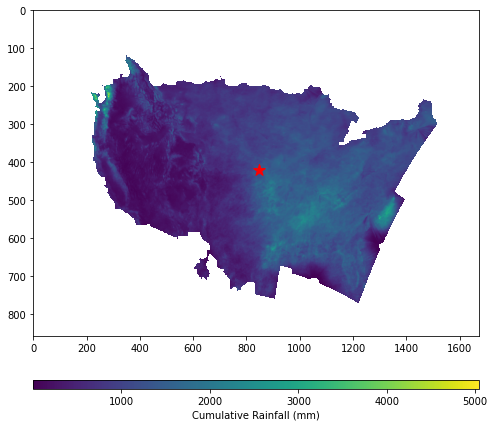

In [15]:
# Plot Map of cummulative rainfall

plt.figure(figsize=(8,8))
plt.imshow(rainfall_mm, aspect='auto')
plt.colorbar(orientation="horizontal", pad=0.1, aspect=50, label="Cumulative Rainfall (mm)")
plt.scatter(row_col[1],row_col[0], marker='*', color='r', s=150)
plt.gca().axes.get_xaxis().set_visible(True)
plt.gca().axes.get_yaxis().set_visible(True)
plt.show()


### Retrieve the rainfall at the closest location to LOI to represent the rainfall at LOI


In [19]:
# Retrieve the rainfall measurement at the nearest location

rainfall_amount = rainfall_mm[row_col]
print('The total rainfall in',LOI,'for the past 365 days', 'is:', round(rainfall_amount,2),'mm')


The total rainfall in Manhattan for the past 365 days is: 1426.16 mm
